In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import gzip
import os
import copy
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from fashion_mnist.utils.mnist_reader import load_mnist

In [3]:
total_train_image, total_train_labels = load_mnist('./fashion_mnist/data/fashion/', kind='train')
test_image, test_labels = load_mnist('./fashion_mnist/data/fashion/', kind='t10k')

In [4]:
ones_array_train = np.ones((total_train_image.shape[0], 1), dtype=int)
ones_array_test = np.ones((test_image.shape[0], 1), dtype=int)

In [5]:
total_train_image = np.hstack((ones_array_train,total_train_image))
test_image = np.hstack((ones_array_test,test_image))

In [6]:
train_image, validation_image = train_test_split(total_train_image, test_size=0.15, random_state=0)
train_labels, validation_labels = train_test_split(total_train_labels, test_size=0.15, random_state=0)

In [7]:
train_labels_onehot = pd.get_dummies(train_labels)
validation_labels_onehot = pd.get_dummies(validation_labels)
test_labels_onehot = pd.get_dummies(test_labels)

In [8]:
def cross_entropy(y, h):
    return tf.reduce_sum(-tf.log(h)*y,1, keepdims=True)

def gradient_update(gradient,h):
    return gradient.assign(tf.tensordot(tf.transpose(X), tf.subtract(h, y),1)/tf.cast(tf.shape(h)[0], dtype=tf.float32))

def theta_update(theta, gradient):
    return theta.assign(theta - lr * gradient)

def pred_y(X,theta):
    return tf.tensordot(X,theta, 1)

def softmax(z):
    exp_num = tf.exp(z)
    sum_div = tf.reduce_sum(exp_num,1, keepdims=True)
    return exp_num / sum_div

In [9]:
lr = 0.01
batch = train_image.shape[0]
epochs = 100
iterations = int(train_image.shape[0]/batch)

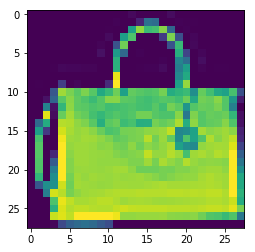

In [10]:
plt.imshow(test_image[30][1:].reshape(28,28))

In [11]:
X = tf.placeholder(tf.float32, shape =([None,28*28+1]))
y = tf.placeholder(tf.float32, shape =([None, 10]))

In [12]:
theta = tf.get_variable("theta", shape=(28*28+1,10), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [13]:
gradient = tf.get_variable("gradient", shape=(28*28+1,10), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [14]:
z = pred_y(X,theta)

In [15]:
h = softmax(z)

In [16]:
loss = cross_entropy(y,h)

In [17]:
tf_X = tf.placeholder(tf.float32)
tf_X_norm = tf.image.per_image_standardization(tf_X)

In [18]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

train_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: train_image})
validation_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: validation_image})
test_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: test_image})

In [ ]:
sess.run(tf.global_variables_initializer())

train_epoch_loss_list = []
validation_epoch_loss_list = []

for i in range(epochs):
    batch_accumulate_loss = 0
    
    print('Epoch {}'.format(i))
    for j in range(iterations):
        index = j*batch

        theta_value = sess.run(theta_update(theta,gradient))
        y_values, h_values, gradient_values, train_loss_value = sess.run([y, h, gradient_update(gradient, h), loss], feed_dict={X:train_image_norm[index:index+batch], y:train_labels_onehot[index:index+batch]})
        batch_accumulate_loss += train_loss_value

    train_epoch_loss = batch_accumulate_loss/iterations
    train_epoch_loss_list.append(train_epoch_loss)
    validation_epoch_loss = sess.run(loss, feed_dict={X:validation_image_norm, y:validation_labels_onehot})
    validation_epoch_loss_list.append(validation_epoch_loss)

    print('Iteration loss:')
    print(train_epoch_loss)
    print('Validation loss:')
    print(validation_epoch_loss)

Epoch 0
Iteration loss:
3.2528626918792725
Validation loss:
3.252307
Epoch 1
Iteration loss:
2.611992597579956
Validation loss:
2.6095412
Epoch 2
Iteration loss:
2.3188490867614746
Validation loss:
2.3163867
Epoch 3


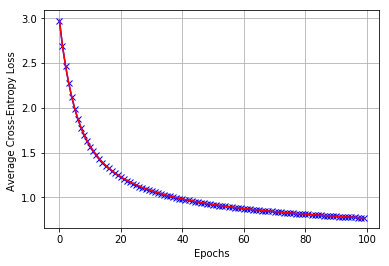

In [20]:
fig = plt.figure(1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Average Cross-Entropy Loss ')
plt.plot(range(len(train_epoch_loss_list)),train_epoch_loss_list, '-bx')
plt.plot(range(len(validation_epoch_loss_list)),validation_epoch_loss_list, '-r')

plt.show()

In [21]:
h_values = sess.run(h, feed_dict={X:test_image_norm})

In [22]:
result_labels = np.zeros_like(h_values,dtype=int)

In [23]:
result_labels[np.arange(len(h_values)), h_values.argmax(1)] = 1

In [24]:
result_labels = np.argmax(result_labels, axis=1)

In [25]:
from sklearn.metrics import f1_score

In [26]:
f1_score(test_labels,result_labels, average='micro')

0.7277

In [27]:
from pandas_ml import ConfusionMatrix

In [28]:
ConfusionMatrix(test_labels,result_labels)

Predicted     0    1    2     3     4     5    6     7    8     9  __all__
Actual                                                                    
0           759   16   17    86    16    25   51     2   28     0     1000
1            23  907   11    40    13     2    3     0    1     0     1000
2            23    0  573     8   194    23  159     0   19     1     1000
3            58   46    6   779    29    12   66     0    4     0     1000
4             2    4  179    52   597    17  137     0   12     0     1000
5             1    0    0     4     0   758    1   147   12    77     1000
6           206    6  145    63   145    53  343     1   38     0     1000
7             0    0    0     0     0   109    0   813    2    76     1000
8             8    3   14    31    17    29   13    23  853     9     1000
9             0    0    1     1     1    40    3    56    3   895     1000
__all__    1080  982  946  1064  1012  1068  776  1042  972  1058    10000